In [298]:
import pandas as pd
import ast
from sklearn import model_selection
from tqdm import tqdm
import shutil
import os

In [299]:
from tqdm import tqdm
import numpy as np

In [300]:
import shutil

In [301]:
DATA_PATH = "./resize_image/"
OUTPUT_PATH = "./damage_data/"

In [302]:
from os import listdir
from os.path import isfile, join
import xml.etree.ElementTree as Xet
import pandas as pd

path = './annot_chem4/'
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]



def parse_xml(file):
    rows = []
    for i in file:
        #print(i)
        cols = ["name", "width", "height", "class_", "bbox"]
        
        c= ''
        bbx = ['xmin', 'ymin', 'xmax', 'ymax']
        # Parsing the XML file
        xmlparse = Xet.parse(path+'/'+i)
        root = xmlparse.getroot()

        name = root[0].text
        width = root.find('size').find('width').text
        height = root.find('size').find('height').text
        count = 0
        bb_list=[]
        bb = ['xmin','ymin', 'xmax','ymax']
        
        for i in range(3,len(root)):
            class_ = root[i].find('name').text
            if class_ == 'Scratch_or_spot':
                c = class_
                b_list=[]
                for a in bb:
                    
                    b_list.append(float(root[i].find('bndbox').find(a).text))
                bb_list.append(b_list)
        coordinates = bb_list
        rows.append({"name": name,
                 "width": width,
                 "height": height,
                 "class_": c,
                 "bbox": coordinates})
        #print(len(rows))
        df = pd.DataFrame(rows, columns=cols)
    return df
parse_xml(onlyfiles).to_csv('train.csv', index=False)   

In [331]:
df = pd.read_csv("train.csv")

In [332]:
df = df[df.class_ == 'Scratch_or_spot'].reset_index(drop=True)

In [333]:
type(df['bbox'][0])

str

In [334]:
print(type(df.bbox[0])) #in string format
df.bbox = df.bbox.apply(ast.literal_eval)
print(type(df.bbox[0])) #list format

<class 'str'>
<class 'list'>


In [335]:
df

,name,width,height,class_,bbox
0,akhand_b43_512.jpg,1024,768,Scratch_or_spot,"[[225.0, 330.0, 430.0, 481.0]]"
1,akhand_b43_520.jpg,1024,768,Scratch_or_spot,"[[355.0, 446.0, 584.0, 532.0]]"
2,akhand_b43_194.jpg,640,480,Scratch_or_spot,"[[288.0, 394.0, 327.0, 440.0], [240.0, 370.0, ..."
3,akhand_b43_275.jpg,1024,768,Scratch_or_spot,"[[336.0, 197.0, 814.0, 277.0]]"
4,akhand_b43_595.jpg,1600,1200,Scratch_or_spot,"[[236.0, 643.0, 298.0, 678.0]]"
...,...,...,...,...,...
170,akhand_b43_359.jpg,800,600,Scratch_or_spot,"[[155.0, 334.0, 230.0, 374.0], [184.0, 407.0, ..."
171,akhand_b43_57.jpg,800,600,Scratch_or_spot,"[[373.0, 495.0, 403.0, 547.0], [400.0, 461.0, ..."
172,akhand_b43_125.jpg,800,600,Scratch_or_spot,"[[297.0, 449.0, 325.0, 491.0]]"
173,akhand_b43_486.jpg,1024,768,Scratch_or_spot,"[[471.0, 379.0, 502.0, 417.0]]"


In [22]:
!mkdir ./damage_data
!mkdir ./damage_data/images
!mkdir ./damage_data/labels
!mkdir ./damage_data/images/train
!mkdir ./damage_data/images/validation
!mkdir ./damage_data/labels/train
!mkdir ./damage_data/labels/validation

In [44]:
!pip install albumentations

     |████████████████████████████████| 72 kB 45 kB/s  eta 0:00:011
     |████████████████████████████████| 948 kB 170 kB/s eta 0:00:01
     |████████████████████████████████| 29.2 MB 45 kB/s  eta 0:00:01
     |████████████████████████████████| 37.6 MB 7.0 kB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 271 kB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 88 kB/s eta 0:00:018
     |████████████████████████████████| 163 kB 890 kB/s eta 0:00:01
  Attempting uninstall: PyWavelets
    Found existing installation: PyWavelets 1.0.2
    Uninstalling PyWavelets-1.0.2:
      Successfully uninstalled PyWavelets-1.0.2
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.14.2
    Uninstalling scikit-image-0.14.2:
      Successfully uninstalled scikit-image-0.14.2
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We re

In [308]:
#image resizeing
from PIL import Image
import numpy as np
import albumentations


In [309]:
def resize_image(img_arr, bboxes, h, w):
    """
    :param img_arr: original image as a numpy array
    :param bboxes: bboxes as numpy array where each row is 'x_min', 'y_min', 'x_max', 'y_max', "class_id"
    :param h: resized height dimension of image
    :param w: resized weight dimension of image
    :return: dictionary containing {image:transformed, bboxes:['x_min', 'y_min', 'x_max', 'y_max', "class_id"]}
    """
    # create resize transform pipeline
    transform = albumentations.Compose(
        [albumentations.Resize(height=h, width=w, always_apply=True)],
        bbox_params=albumentations.BboxParams(format='pascal_voc'))

    transformed = transform(image=img_arr, bboxes=bboxes)

    return transformed


In [310]:
df_new = df.copy()
for i in range(0,len(df_new.name)):
    sample = Image.open(os.path.join('./images_chem4',df_new.name[i]))
    sample_arr = np.asarray(sample)
    if len(df_new.bbox[i]) == 1:
        A = df_new.bbox[i][0]
        A.append(['scratch'])
        a= np.array(A)[np.newaxis]
#         transformed_dict = resize_image(sample_arr, a, np.min(df.height), np.min(df.width))
        transformed_dict = resize_image(sample_arr, a, 512, 512)
        im = Image.fromarray(transformed_dict["image"])
        im.save(f"./resize_image/{df_new.name[i]}")
        B = list(transformed_dict["bboxes"][0])
        B.remove(['scratch'])
        df_new.bbox[i][0] = B
    if len(df_new.bbox[i]) != 1:
        for j in range(0,len(df_new.bbox[i])):
            A = df_new.bbox[i][j]
            A.append(['scratch'])
            a= np.array(A)[np.newaxis]
            transformed_dict = resize_image(sample_arr, a, np.min(df.height), np.min(df.width))
            im = Image.fromarray(transformed_dict["image"])
            im.save(f"./resize_image/{df_new.name[i]}")
            B = list(transformed_dict["bboxes"][0])
            B.remove(['scratch'])
            df_new.bbox[i][j] = B  


/home/akansh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
/home/akansh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [312]:
df

,name,width,height,class_,bbox
0,akhand_b43_512.jpg,1024,768,Scratch_or_spot,"[[112.5, 220.0, 215.0, 320.6666666666667]]"
1,akhand_b43_520.jpg,1024,768,Scratch_or_spot,"[[177.5, 297.3333333333333, 292.0, 354.6666666..."
2,akhand_b43_194.jpg,640,480,Scratch_or_spot,"[[288.0, 295.5, 327.0, 330.0], [240.0, 277.5, ..."
3,akhand_b43_275.jpg,1024,768,Scratch_or_spot,"[[168.0, 131.33333333333334, 407.0, 184.666666..."
4,akhand_b43_595.jpg,1600,1200,Scratch_or_spot,"[[75.52, 274.3466666666667, 95.36, 289.28]]"
...,...,...,...,...,...
170,akhand_b43_359.jpg,800,600,Scratch_or_spot,"[[124.0, 200.39999999999998, 184.0, 224.399999..."
171,akhand_b43_57.jpg,800,600,Scratch_or_spot,"[[298.4, 297.0, 322.40000000000003, 328.2], [3..."
172,akhand_b43_125.jpg,800,600,Scratch_or_spot,"[[190.08, 383.14666666666665, 208.0, 418.98666..."
173,akhand_b43_486.jpg,1024,768,Scratch_or_spot,"[[235.5, 252.66666666666666, 251.0, 278.0]]"


In [313]:
df.width = 512
df.height = 512

In [314]:
df_train, df_valid = model_selection.train_test_split(
df,
test_size=0.08,
random_state=42,
shuffle = True)

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

In [315]:
df

,name,width,height,class_,bbox
0,akhand_b43_512.jpg,512,512,Scratch_or_spot,"[[112.5, 220.0, 215.0, 320.6666666666667]]"
1,akhand_b43_520.jpg,512,512,Scratch_or_spot,"[[177.5, 297.3333333333333, 292.0, 354.6666666..."
2,akhand_b43_194.jpg,512,512,Scratch_or_spot,"[[288.0, 295.5, 327.0, 330.0], [240.0, 277.5, ..."
3,akhand_b43_275.jpg,512,512,Scratch_or_spot,"[[168.0, 131.33333333333334, 407.0, 184.666666..."
4,akhand_b43_595.jpg,512,512,Scratch_or_spot,"[[75.52, 274.3466666666667, 95.36, 289.28]]"
...,...,...,...,...,...
170,akhand_b43_359.jpg,512,512,Scratch_or_spot,"[[124.0, 200.39999999999998, 184.0, 224.399999..."
171,akhand_b43_57.jpg,512,512,Scratch_or_spot,"[[298.4, 297.0, 322.40000000000003, 328.2], [3..."
172,akhand_b43_125.jpg,512,512,Scratch_or_spot,"[[190.08, 383.14666666666665, 208.0, 418.98666..."
173,akhand_b43_486.jpg,512,512,Scratch_or_spot,"[[235.5, 252.66666666666666, 251.0, 278.0]]"


In [316]:
def process_data(data, data_type = 'train'):
    for _, row in tqdm(data.iterrows(), total = len(data)):
        image_name = row['name']
        bounding_boxes = row['bbox']
        yolo_data = []
        for bbox in bounding_boxes:
            x_min = bbox[0]
            y_min = bbox[1]
            x_max = bbox[2]
            y_max = bbox[3]

            x_center = (x_min+x_max)/2.0
            y_center = (y_min+y_max)/2.0

            x_center /= 512.0
            y_center /= 512.0
            w = (x_max - x_min)/512.0
            h = (y_max - y_min)/512.0

            yolo_data.append([0, x_center, y_center, w,h])
        np.savetxt(
                os.path.join(OUTPUT_PATH, f"labels/{data_type}/{image_name[:-4]}.txt"), 
                yolo_data,
                fmt = ["%d", "%f", "%f","%f","%f"]

            )
        shutil.copyfile(
                os.path.join(DATA_PATH, f"{image_name}"),
                os.path.join(OUTPUT_PATH, f"images/{data_type}/{image_name}")
            )
    

In [317]:
process_data(df_train, data_type="train")
process_data(df_valid, data_type="validation")

100%|██████████| 14/14 [00:00<00:00, 522.35it/s]


In [336]:
(df[df.name == 'akhand_b43_137.jpg'].bbox.values)

array([list([[424.0, 348.0, 520.0, 557.0]])], dtype=object)

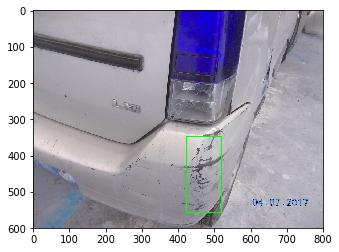

In [337]:
image = cv2.imread('./images_chem4/akhand_b43_137.jpg')

##tansform

plt.imshow(cv2.rectangle(image ,(int(424.0),int(348.0)), (int(520.0),int(557.0)), (0,255,0) , 2))

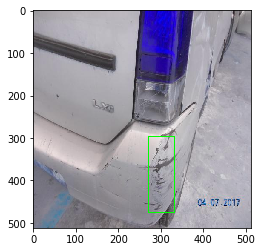

In [330]:
df[df.name == 'akhand_b43_137.jpg'].bbox.values

import cv2
image = cv2.imread('./resize_image/akhand_b43_137.jpg')


import matplotlib.pyplot as plt

##tansform

plt.imshow(cv2.rectangle(image ,(int(271.36),int(296.96)), (int(332.8),int(475.306666666666)), (0,255,0) , 2))